Start basic: following along with the starter kit and using cesium for the first time to wrangle data, I ended up applying a simple sklearn model to this data and found that the amplitude of all the fluxes of all the filters for all the sources is NOT a sufficent proxy for the type of event. Will continue this research into more sophisticated techniques next, but for now here's a step by step procedure of how to clean/sample/explore the dataset. 

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from operator import itemgetter
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import schwimmbad

#typically I use pandas, but it doesn't conform to the code used for starting up :) 
from astropy.table import Table
import os
import sys

In [2]:
data = Table.read('../data/training_set.csv',format='csv')
#meta_data = pd.read_csv('../data/training_set_metadata.csv')
meta_data = Table.read('../data/training_set_metadata.csv', format='csv')


In [3]:
meta_data

object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,nan,0.017,92
713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
730,33.574219,-6.579593,170.455585,-61.548219,1,0.232,0.2262,0.0157,40.2561,0.021,42
745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,nan,0.02,65
1598,347.84671,-64.760857,318.929827,-49.143596,1,0.1352,0.182,0.0304,39.7279,0.019,90
1632,348.595886,-63.07262,320.023289,-50.71306,1,0.6857,0.7014,0.01,43.1524,0.021,42
1920,149.414062,3.433834,234.919132,42.24555,1,0.3088,0.3229,0.336,41.1401,0.027,90


In [4]:
data

object_id,mjd,passband,flux,flux_err,detected
int64,float64,int64,float64,float64,int64
615,59750.4229,2,-544.810303,3.622952,1
615,59750.4306,1,-816.434326,5.55337,1
615,59750.4383,3,-471.385529,3.801213,1
615,59750.445,4,-388.984985,11.395031,1
615,59752.407,2,-681.858887,4.041204,1
615,59752.4147,1,-1061.457031,6.472994,1
615,59752.4224,3,-524.95459,3.552751,1
615,59752.4334,4,-393.480225,3.599346,1
615,59752.4435,5,-355.88678,10.421921,1


<IPython.core.display.Javascript object>


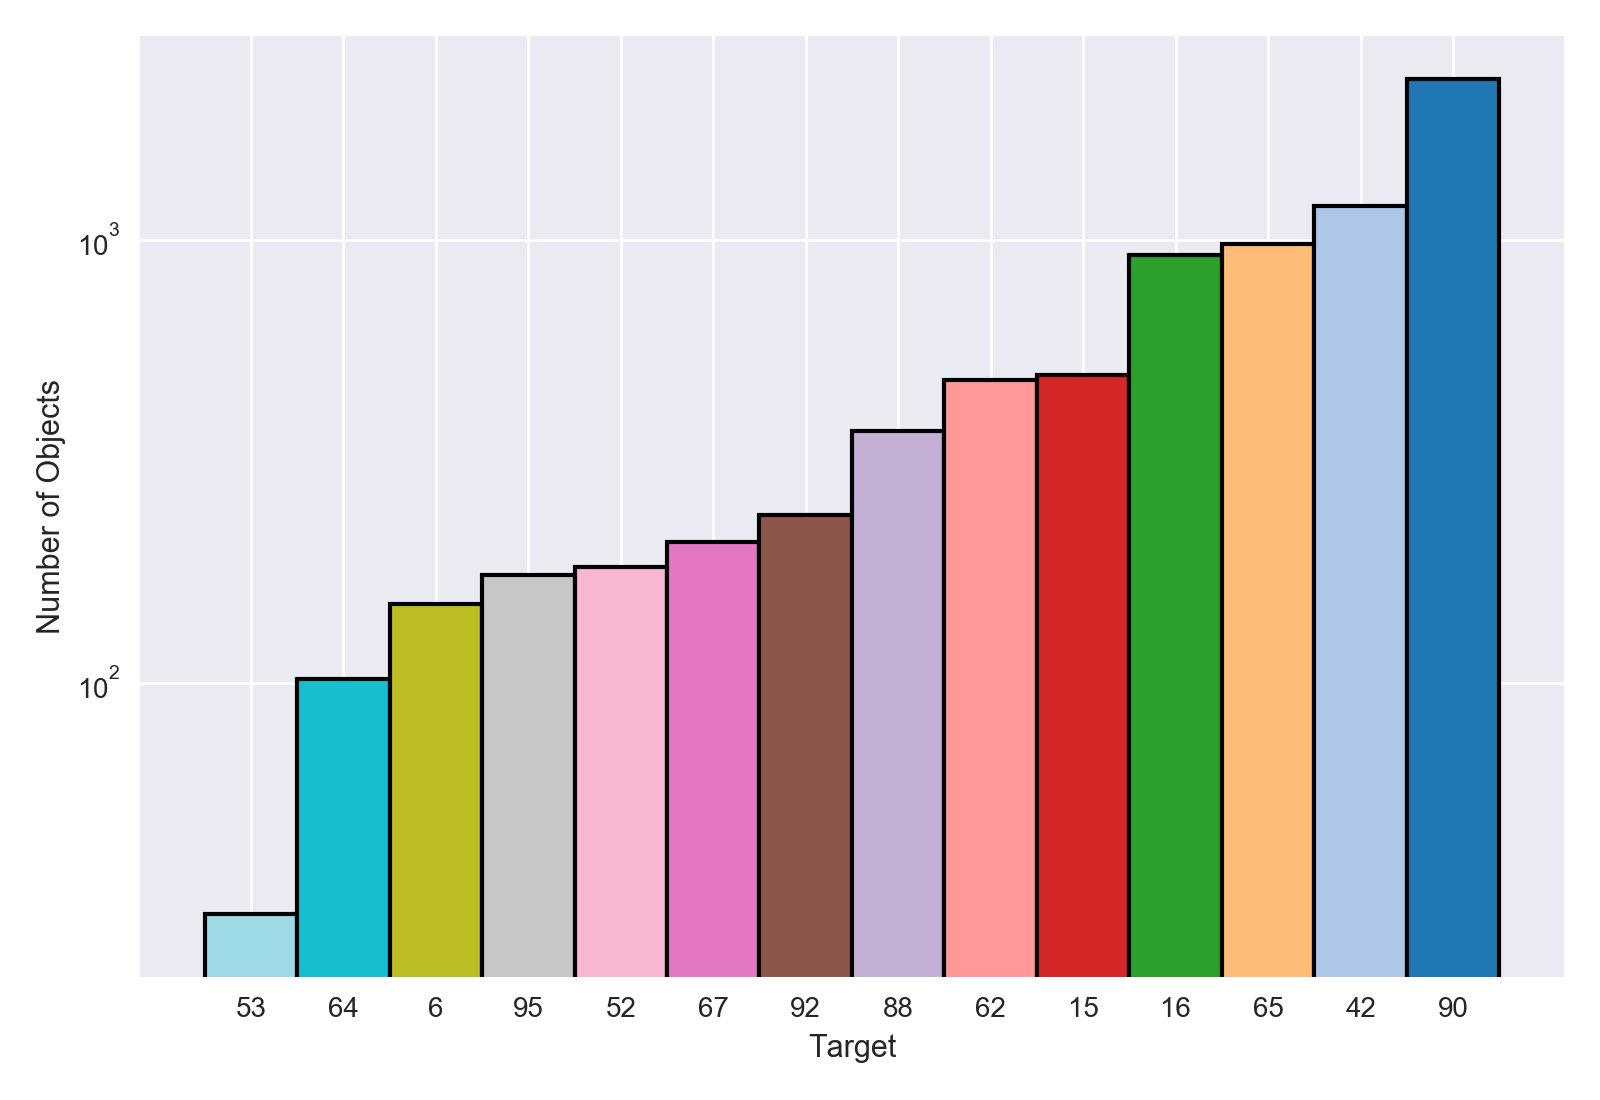

In [17]:
counts = Counter(meta_data['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

This bar graph quickly shows a disparity in the labelled objects, which while not unusual for astronomy, just means to be wary of misleading predictions (ie if all objects were classified as the most common it would retain a good accuracy, but still not meean much. 

In [7]:

"""

WARNING: This broke my code on my local disk so don't run it! Iterating over 1.4 milion rows has
consequences!
wfd_data = []
for i,row in enumerate(data['object_id']):
  #  print(row)
    if row in wfd_meta_data['object_id'].values:
        wfd_data.append(data.values[i])
        
"""

"\n\nWARNING: This broke my code on my local disk so don't run it! Iterating over 1.4 milion rows has\nconsequences!\nwfd_data = []\nfor i,row in enumerate(data['object_id']):\n  #  print(row)\n    if row in wfd_meta_data['object_id'].values:\n        wfd_data.append(data.values[i])\n        \n"

This is taken from the starter kit. It is a basic mapping used to go from the passband name from the integer

In [8]:


pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [9]:
lcdata = data  #light curve data
nobjects = len(meta_data)  #number of sources

tsdict = OrderedDict()  #create a dictionary for each time series
for i in tnrange(nobjects, desc='Building Timeseries'): #descending order
    row = meta_data[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]  #mask individual passpands
    t = [thislc['mjd'][mask].data for mask in pbind ]  # mask of times for specific passband
    m = [thislc['flux'][mask].data for mask in pbind ] #mask of flux at the same times for this passband
    e = [thislc['flux_err'][mask].data for mask in pbind ] #mask for flux errors for this passband

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del lcdata

What is this timeseries blob doing? 

Creates a "timeseries" object for each lightcurve. Each lightcurve is uniquely classified based on it object id and target

The resulting tsdict contains 7848 keys, where each is a time series object in itself where the values are further distingueshed based on the passband used. 

So in the end, each one of these 7848 time series objects will contain smaller subsets within contianing the unique passbands, and inside each of those is the flux, mjd, and errors. 

In [10]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [11]:

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]


In [12]:
featurefile = '../data/plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with schwimmbad.MultiPool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              timet_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

Below is a quick refresher for how these time series objects operate. Below I have outputted a few values, where it corresponds to the 615 object, the first source captured, and where the .time attribute is all of the time recorded, where the index 0 corresponds to one of the filters. For the flux readings and actual name of this filter, the corresponding index is then used for the measuerment and channel name attributes. Finally, the label attribute, just gives the assign label for this huge conglomeration of data, making it possible to perform some kind of supervised learning. 

In [13]:
tsdict[615].time[0]

array([ 59819.1532,  59820.1047,  59821.1026,  59822.1105,  59823.1505,
        59851.1114,  59874.0599,  59875.0311,  59876.0231,  59877.0238,
        59878.0246,  59879.0248,  59880.0258,  60118.4163,  60140.229 ,
        60141.2225,  60142.2202,  60143.2212,  60144.2186,  60145.2123,
        60176.1332,  60177.137 ,  60198.1077,  60199.0914,  60200.065 ,
        60201.068 ,  60202.0552,  60206.1107,  60207.1469,  60228.0187,
        60229.0162,  60234.0265,  60260.0423,  60261.0361,  60262.0367,
        60263.0373,  60264.0465,  60499.2467,  60500.2437,  60501.2385,
        60502.2355,  60524.239 ,  60525.1736,  60554.0964,  60555.0951,
        60556.0879,  60557.0831,  60558.1093,  60559.1097,  60560.1065,
        60582.084 ,  60583.0169,  60584.0117,  60585.0117,  60586.0123,
        60587.0127,  60588.0131,  60612.0266,  60613.0269,  60614.0276,
        60615.0375,  60616.029 ,  60617.0295])

In [14]:
tsdict[615].measurement[0]

array([   6.878784,   39.364853,  -10.422381,  -65.48513 , -113.349159,
        -68.502457,  -97.353195,  -97.52388 , -108.672577, -116.913223,
       -102.768921,  -52.407089,   55.567715, -107.080536,  -88.981155,
        -50.179337,   50.00864 ,  110.753555,  120.867218,  111.464226,
        -49.905262,  -87.160583,  100.12928 ,   86.776741,   82.078186,
         41.947815,    9.061676,  -83.072884,  108.483109,    6.768485,
        -35.14933 ,  -52.922794,  108.020546,  125.182808,  107.64978 ,
         61.068066,   -9.100937,  106.447296,   67.234062,   24.868933,
        -15.392517,   89.070496,  118.935989,   82.168922,   49.886921,
          9.075453,  -30.764908, -101.419899, -110.688477, -114.774445,
        -51.614189,   20.364273,  -24.682575,  -63.5466  , -101.81929 ,
       -110.978699, -113.588432, -110.649872,  -89.973892,  -10.015225,
         99.438087,  120.849113,  121.411896])

In [15]:
tsdict[615].channel_names[0]

'u'

<IPython.core.display.Javascript object>


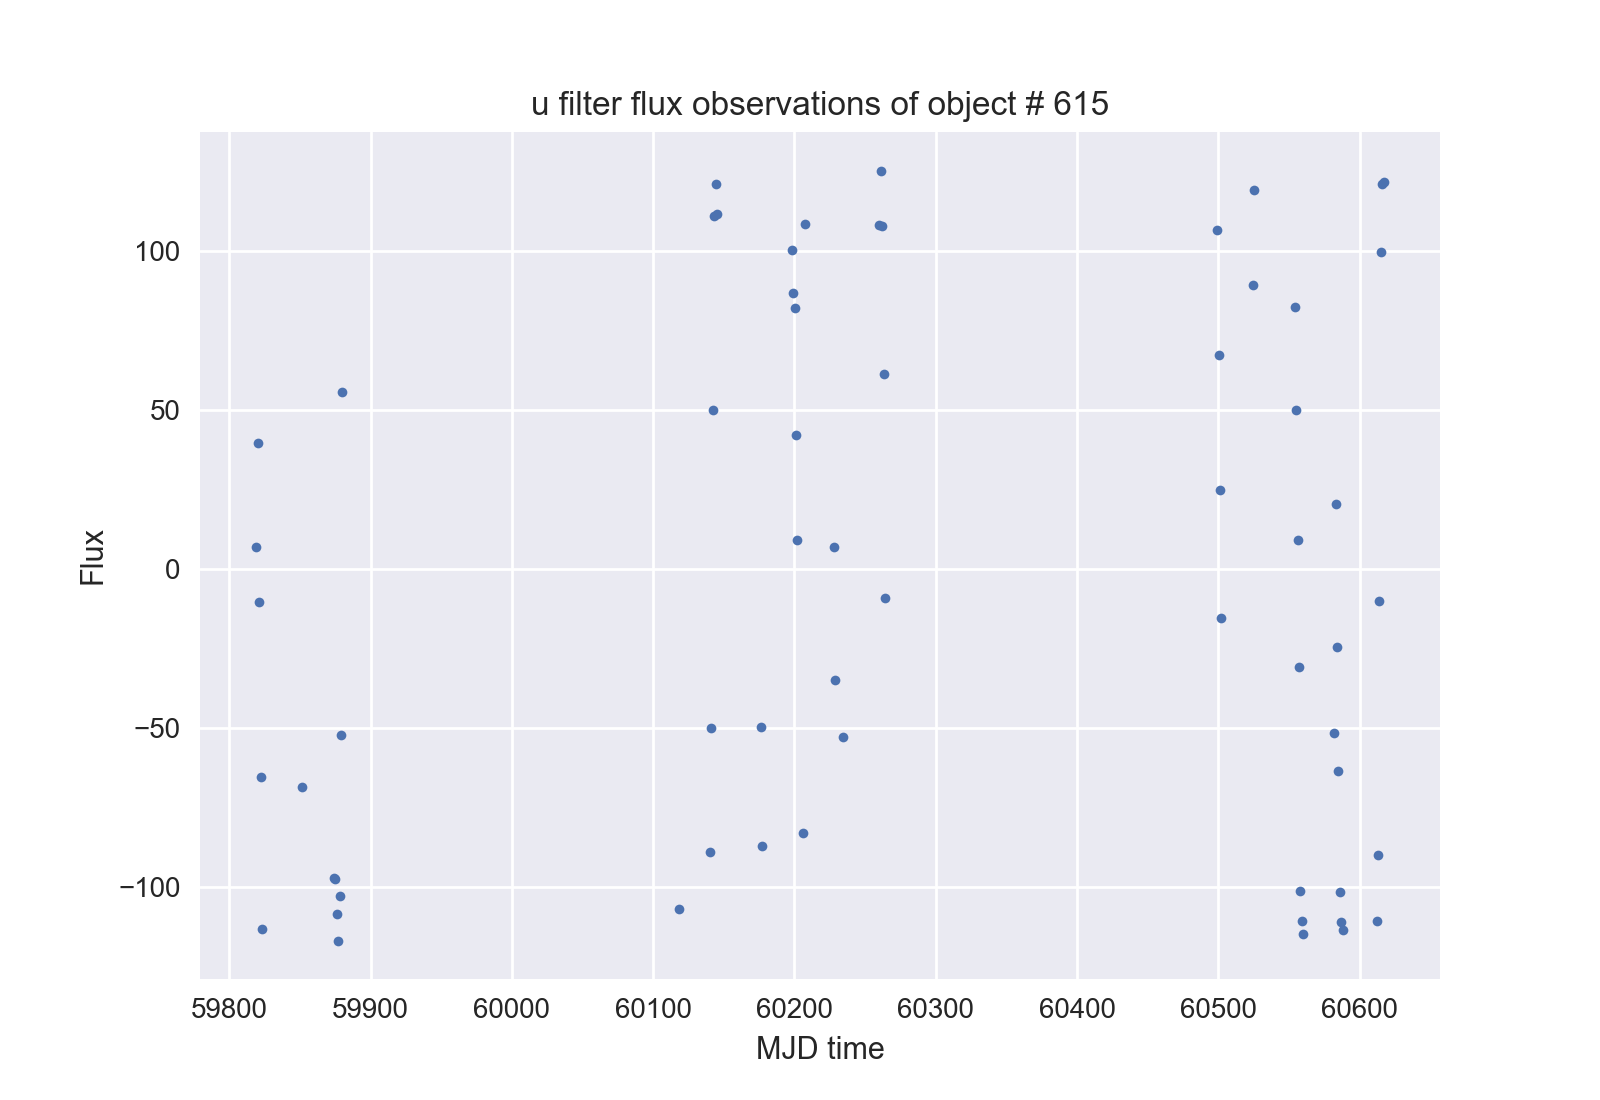

In [39]:
plt.figure()
plt.plot(tsdict[615].time[0],tsdict[615].measurement[0],'.')
plt.title(tsdict[615].channel_names[0] + " filter flux observations of object # 615")
plt.xlabel("MJD time")
plt.ylabel("Flux")

In [42]:
max(tsdict[615].measurement[0])

125.18280799999999

In [43]:
np.mean(tsdict[615].measurement[0])

-3.2545543809523818

In [19]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

In [20]:
allfeats

amplitude_u,amplitude_g,amplitude_r,amplitude_i,amplitude_z,amplitude_y,percent_beyond_1_std_u,percent_beyond_1_std_g,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_y,maximum_u,maximum_g,maximum_r,maximum_i,maximum_z,maximum_y,max_slope_u,max_slope_g,max_slope_r,max_slope_i,max_slope_z,max_slope_y,median_u,median_g,median_r,median_i,median_z,median_y,median_absolute_deviation_u,median_absolute_deviation_g,median_absolute_deviation_r,median_absolute_deviation_i,median_absolute_deviation_z,median_absolute_deviation_y,percent_close_to_median_u,percent_close_to_median_g,percent_close_to_median_r,percent_close_to_median_i,percent_close_to_median_z,percent_close_to_median_y,minimum_u,minimum_g,minimum_r,minimum_i,minimum_z,minimum_y,skew_u,skew_g,skew_r,skew_i,skew_z,skew_y,std_u,std_g,std_r,std_i,std_z,std_y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_y,mwebv_meta,z_meta,zerr_meta
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
121.0480155,880.533203,646.9217225,488.1908265,402.069122,400.5016175,0.47619047619,0.586206896552,0.568965517241,0.551724137931,0.51724137931,0.59649122807,125.182808,660.626343,611.984558,445.737061,381.953735,378.188141,184.863919127,594.695676571,423.361103947,280.05519209,205.475910711,226.111644844,-10.015225,-488.0579685,-265.6860045,-162.1709445,-103.5413665,-85.524307,79.958667,509.2487545,368.12851,314.0894465,276.5943145,291.94963,0.15873015873,0.172413793103,0.172413793103,0.120689655172,0.155172413793,0.0877192982456,-116.913223,-1100.440063,-681.858887,-530.644592,-422.184509,-422.815094,0.125826733268,0.404754547091,0.331063486729,0.285491645091,0.194883100723,0.121947542843,83.2758418309,596.576923979,451.180827181,332.520884978,289.276964659,292.182294769,-17.0611175242,-212.397193454,-102.220639087,-101.206639465,-54.7448448337,-59.6883791705,0.017,0.0,0.0
14.6225035,10.422385,10.29848,11.8624545,11.0573675,14.491025,0.385714285714,0.392857142857,0.410714285714,0.410714285714,0.375,0.392857142857,14.509829,9.129021,10.529041,11.330316,9.827934,14.770886,11.4187333064,1.73872343997,1.79863513417,2.73098306918,3.60765560234,6.12854996624,-3.0968045,-0.5617355,-0.1179765,-0.0738965,-0.7921755,-2.4630115,6.054598,4.696852,5.1003545,5.484658,5.3961835,5.702667,0.2,0.214285714286,0.178571428571,0.214285714286,0.160714285714,0.232142857143,-14.735178,-11.715749,-10.067919,-12.394593,-12.286801,-14.211164,0.254446028902,-0.085493520645,-0.0220662452034,-0.162663960528,-0.0624028790186,0.212294126849,7.06251570271,5.66110147704,5.71898140764,6.39256065605,6.3495262302,7.03044760467,-3.50095848708,-1.32239725566,-1.03046874714,-1.38294086464,-1.40787862106,-1.8763990837,0.007,1.6267,0.2552
4.701063,4.5430945,11.9217745,19.5039505,23.4981455,33.234935,0.333333333333,0.442307692308,0.134615384615,0.115384615385,0.0980392156863,0.21568627451,5.942166,5.693109,20.994711,33.572102,41.159981,47.310059,5.987811461,2.43637626535,2.12803090673,3.72768245425,3.04558089501,5.93550085674,0.024093,0.1713355,0.4917905,0.6604025,1.004354,2.542647,1.2058455,0.995237,1.042533,2.0189215,2.596185,5.693106,0.347222222222,0.5,0.769230769231,0.75,0.745098039216,0.56862745098,-3.45996,-3.39308,-2.848838,-5.435799,-5.83631,-19.159811,0.349430775391,0.457635337315,2.31570714343,2.58466092589,2.46254227092,1.63052028324,1.81612723737,1.78976697383,5.5057671031,8.11283545649,10.6048212426,13.201397335,-0.0164227662621,-0.03

This table now contains some simple population statistics about each of the sources. 

My next attempt will be to try and identify the most correlated filters in order to save space, and start with the one most correlated to the label. Next I would want to create a recurrent neural net, and see if the time series variations in that can relay any useful information regarding the source's classification. 

In [24]:
ts_objects = tsdict.keys()

7848

In [27]:
allfeats.Column

astropy.table.column.Column

In [28]:
type(allfeats)

astropy.table.table.Table

In [29]:
df = allfeats.to_pandas()

df['target'] = meta_data.to_pandas()['target']





X = df[['amplitude_u','amplitude_g','amplitude_r','amplitude_i','amplitude_z','amplitude_y']].values
y = df['target'].values
#y = pd.get_dummies(y).values

Can you classify the source based on the amplitutde of it's varying flux's in each of it's varying filters? 

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [70]:
mlp = MultiOutputClassifier(MLPClassifier())
model = MultiOutputClassifier(MLPClassifier())
model = MLPClassifier()

In [69]:
mlp.fit(X_train,y_train)

ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [54]:
mlp.score(X_test,y_test)

0.22120285423037717

In [58]:
from sklearn.metrics import confusion_matrix


In [71]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [72]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

<IPython.core.display.Javascript object>


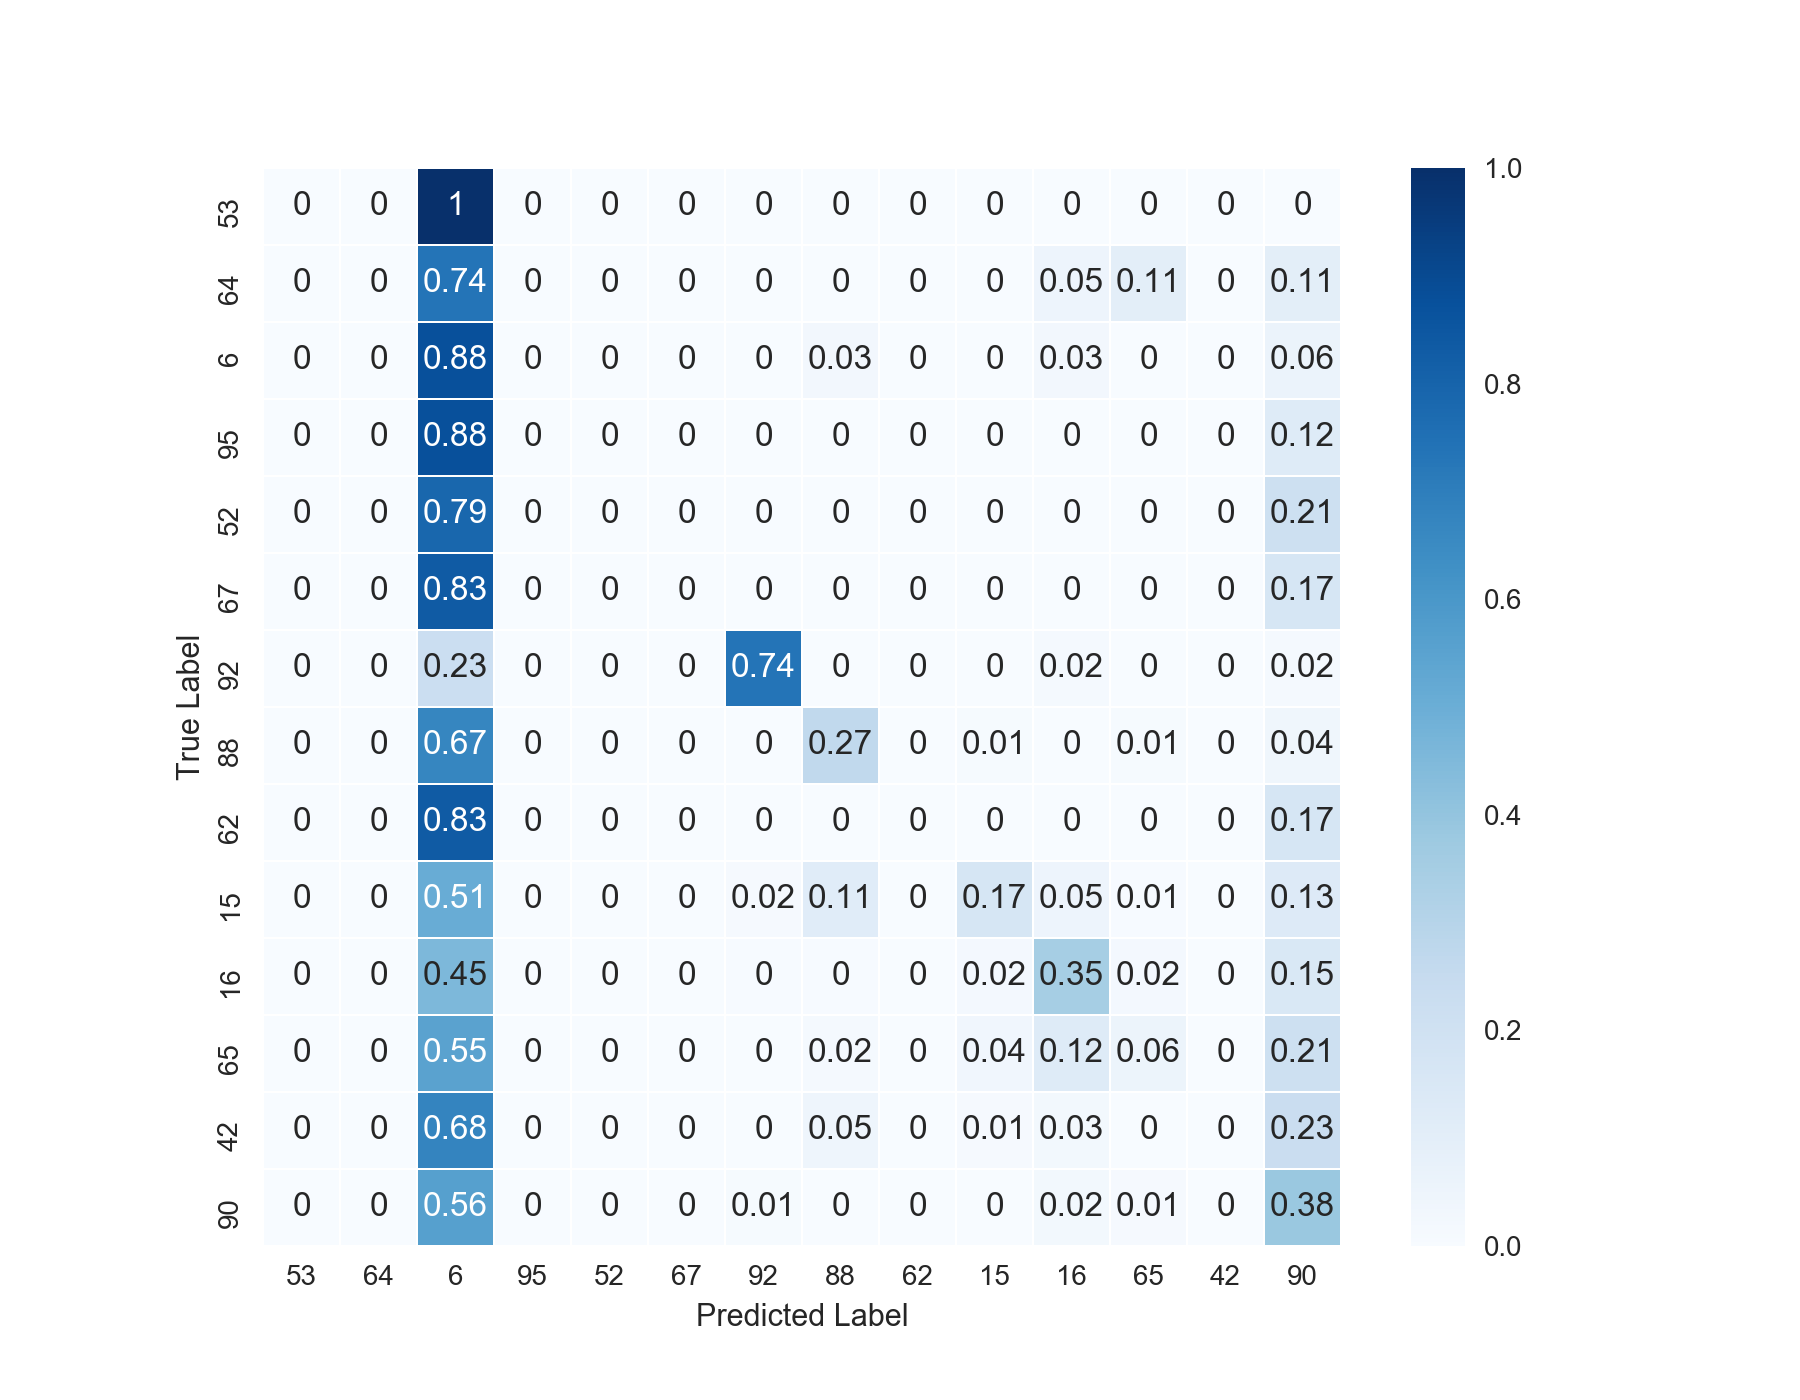

In [73]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

Ok so again this method works fairly poorly. But for good practice, let's apply the test metric to confirm this is at least going in the correct direction. 

In [74]:
def plasticc_log_loss(y_true, y_pred, relative_class_weights=None):
        """
        Implementation of weighted log loss used for the Kaggle challenge
        """
        predictions = y_pred.copy()

        # sanitize predictions
        epsilon = sys.float_info.epsilon # this is machine dependent but essentially prevents log(0)
        predictions = np.clip(predictions, epsilon, 1.0 - epsilon)
        predictions = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

        predictions = np.log(predictions)
        # multiplying the arrays is equivalent to a truth mask as y_true only contains zeros and ones
        class_logloss = []
        for i in range(predictions.shape[1]):
            # average column wise log loss with truth mask applied
            result = np.average(predictions[:, i][y_true[:, i] == 1])
            class_logloss.append(result)
        return -1 * np.average(class_logloss, weights=relative_class_weights)

In [79]:
# we didn't release the weights with the contest at Kaggle's request
# they have been probed through the leaderboard though
# we leave the reader to adjust this as they see fit
# the official metric is always what is on Kaggle's leaderboard. 
# This notebook is solely for demonstration.
weights = np.ones(nlines)


# we want the actual prediction probabilities
y_pred = model.predict_proba(X_test)

# we also need to express the truth table as a matrix
sklearn_truth = np.zeros((len(y_test), nlines))
label_index_map = dict(zip(model.classes_, np.arange(nlines)))
for i, x in enumerate(y_test):
    sklearn_truth[i][label_index_map[y_test[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, y_pred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

LogLoss: 10.493
